## 

## Medical Image Segmentation and Applications (MISA)
## Brain tissue segmentation - IBSR18 PROJECT
Taiabur Rahman

Medical Imaging and Application (MAIA), Universitat de Girona.

Image sets- 

training images: 10 (with GT)

validation images: 5 (with GT)

testing images: 3 (NO GT)

In [7]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tabulate import tabulate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU

from utils.metrics import dice_score_per_class, hausdorff_distance_per_class, ravd_per_class
from utils.patches import extract_useful_patches
from utils.visualization import image_show_with_mask, image_show_only, boxplot

In [8]:

# Image size
SIZE_X = 128
SIZE_Y = 128
N_CLASSES = 4

# Training Images List
train_images = []
validation_images = []
test_images = []

# Mask/Label info as a list
train_masks = []
validation_masks = []

# Dataset path define
base_path = "TrainingValidationTestSets/"
# Training images path
train_img_path = os.path.join(base_path, "Training_Set")
# Validation images path 
validation_img_path = os.path.join(base_path, "Validation_Set")
# Test images path
test_img_path = os.path.join(base_path, "Test_Set")


In [9]:

# Load and preprocess the training data
train_images = []
train_masks = []
for directory_path in glob.glob(os.path.join(train_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            train_images.append(img_data)
        else:
            train_masks.append(img_data)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Load and preprocess the validation data
validation_images = []
validation_masks = []
for directory_path in glob.glob(os.path.join(validation_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            validation_images.append(img_data)
        else:
            validation_masks.append(img_data)

validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

# Load and preprocess the test data
test_images = []
test_image_names = []
for directory_path in glob.glob(os.path.join(test_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            test_images.append(img_data)
            base_name = os.path.basename(image_path).replace('.nii.gz', '')
            test_image_names.append(base_name)


test_images = np.array(test_images)

In [4]:
# Array shape
print("Training Images: ", train_images.shape)
print("Validation Images: ", validation_images.shape)
print("Test Images: ", test_images.shape)

print("Training Mask: ", train_masks.shape)
print("Validation Mask: ", validation_masks.shape)

Training Images:  (10, 256, 128, 256, 1)
Validation Images:  (5, 256, 128, 256, 1)
Test Images:  (3, 256, 128, 256, 1)
Training Mask:  (10, 256, 128, 256, 1)
Validation Mask:  (5, 256, 128, 256, 1)


In [9]:
# print("Training Images")
# image_show_with_mask(train_images,train_masks)
# print("Validation Images")
# image_show_with_mask(validation_images,validation_masks)
# print("Test Images")
# image_show_only(test_images)

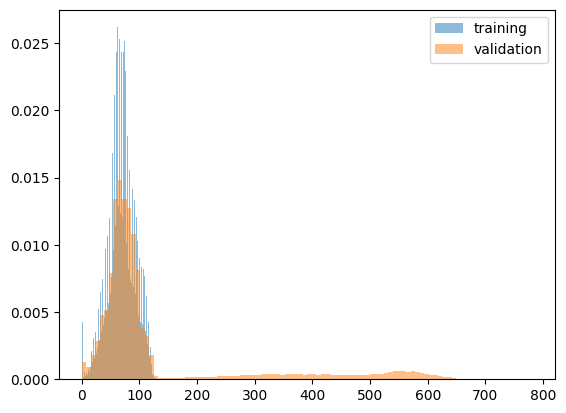

In [6]:
plt.hist(train_images[train_masks>0].flatten(), 100, label='training', alpha=0.5, density=True)
plt.hist(validation_images[validation_masks>0].flatten(), 100, label='validation', alpha=0.5, density=True)
plt.legend(loc='upper right')
plt.show()

In [7]:
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (16, 16)
IMAGE_SIZE = (256, 128, 256)

N_INPUT_CHANNELS = 1
SCALING_FACTOR = 1

# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10
MODEL_FOLDER = 'checkpoint'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'
learning_rate = 0.001

In [8]:
# Split the training data into training (80%) and validation (20%)
train_data, val_data, train_labels, val_labels = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

In [9]:
patch_train_data, patch_train_label = extract_useful_patches(train_data, train_labels)
patch_val_data, patch_val_label = extract_useful_patches(val_data, val_labels)

2024-01-13 03:29:22.129487: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# train and validation patch shape
print("Training : ", patch_train_data.shape)
print("Validation : ", patch_val_data.shape)

print("Training Mask: ", patch_train_label.shape)
print("Validation Mask: ", patch_val_label.shape)

Training :  (36201, 32, 32, 1)
Validation :  (14161, 32, 32, 1)
Training Mask:  (36201, 32, 32, 4)
Validation Mask:  (14161, 32, 32, 4)


In [11]:
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scaling_factor=SCALING_FACTOR):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scaling_factor, (3, 3), padding="same", activation='relu')(inputs)
    drop1 = layers.Dropout(rate=0.3)(conv1, training=True)
    max1 = layers.MaxPooling2D((2, 2))(drop1)

    conv2 = layers.Conv2D(64*scaling_factor, (3, 3), padding="same", activation='relu')(max1)
    drop2 = layers.Dropout(rate=0.3)(conv2, training=True)
    max2 = layers.MaxPooling2D((2, 2))(drop2)

    conv3 = layers.Conv2D(128*scaling_factor, (3, 3), padding="same", activation='relu')(max2)
    drop3 = layers.Dropout(rate=0.3)(conv3, training=True)
    max3 = layers.MaxPooling2D((2, 2))(drop3)

    lat = layers.Conv2D(256*scaling_factor, (3, 3), padding="same", activation='relu')(max3)
    drop_lat = layers.Dropout(rate=0.3)(lat, training=True)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(drop_lat)
    cat1 = layers.Concatenate()([up1, conv3])
    conv4 = layers.Conv2D(128*scaling_factor, (3, 3), padding="same", activation='relu')(cat1)
    drop4 = layers.Dropout(rate=0.3)(conv4, training=True)

    up2 = layers.UpSampling2D((2, 2))(drop4)
    cat2 = layers.Concatenate()([up2, conv2])
    conv5 = layers.Conv2D(64*scaling_factor, (3, 3), padding="same", activation='relu')(cat2)
    drop5 = layers.Dropout(rate=0.3)(conv5, training=True)

    up3 = layers.UpSampling2D((2, 2))(drop5)
    cat3 = layers.Concatenate()([up3, conv1])
    conv6 = layers.Conv2D(32*scaling_factor, (3, 3), padding="same", activation='relu')(cat3)
    drop6 = layers.Dropout(rate=0.3)(conv6, training=True)

    output1 = layers.Conv2D(n_classes, (1, 1), activation="softmax")(drop6)

    model = keras.Model(inputs, output1)

    return model

In [12]:
# class myCallback(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs=None):
#         self.losses = []

#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get("loss") < 0.1):
#             print("\nLoss is low so stop training")
#             self.model.stop_training = True
#             self.losses.append(logs['loss'])
#             plt.plot(self.losses, label='Training Loss')
#             plt.xlabel('Epoch')
#             plt.ylabel('Loss')
#             plt.title('Training Loss Over Time')
#             plt.legend()
#             plt.show()
            
# callbacks = myCallback()

In [13]:
unet = get_unet()

In [14]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FOLDER, save_best_only=True)
]
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

unet.compile(optimizer=optimizer, loss=[LOSS, 'mse'], metrics=[MeanIoU(num_classes=N_CLASSES)])
h = unet.fit(
    x=patch_train_data,
    y=patch_train_label,
    validation_data=(patch_val_data, patch_val_label),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/50
1132/1132 [==============================] - ETA: 0s - loss: 0.4238 - mean_io_u: 0.4190INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 86s 74ms/step - loss: 0.4238 - mean_io_u: 0.4190 - val_loss: 0.3065 - val_mean_io_u: 0.4334
Epoch 2/50
1131/1132 [============================>.] - ETA: 0s - loss: 0.2674 - mean_io_u: 0.4243INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 80s 71ms/step - loss: 0.2674 - mean_io_u: 0.4243 - val_loss: 0.2719 - val_mean_io_u: 0.4163
Epoch 3/50
1132/1132 [==============================] - ETA: 0s - loss: 0.2259 - mean_io_u: 0.4288INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 75s 66ms/step - loss: 0.2259 - mean_io_u: 0.4288 - val_loss: 0.2665 - val_mean_io_u: 0.4314
Epoch 4/50
1132/1132 [==============================] - ETA: 0s - loss: 0.2070 - mean_io_u: 0.4332INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 76s 67ms/step - loss: 0.2070 - mean_io_u: 0.4332 - val_loss: 0.2468 - val_mean_io_u: 0.4340
Epoch 5/50
1132/1132 [==============================] - 71s 63ms/step - loss: 0.1944 - mean_io_u: 0.4369 - val_loss: 0.2582 - val_mean_io_u: 0.4280
Epoch 6/50
1132/1132 [==============================] - 72s 64ms/step - loss: 0.1844 - mean_io_u: 0.4396 - val_loss: 0.2512 - val_mean_io_u: 0.4428
Epoch 7/50
1132/1132 [==============================] - 69s 61ms/step - loss: 0.1784 - mean_io_u: 0.4395 - val_loss: 0.2586 - val_mean_io_u: 0.4330
Epoch 8/50
1131/1132 [============================>.] - ETA: 0s - loss: 0.1725 - mean_io_u: 0.4447INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 72s 63ms/step - loss: 0.1725 - mean_io_u: 0.4447 - val_loss: 0.2455 - val_mean_io_u: 0.4300
Epoch 9/50
1132/1132 [==============================] - 69s 61ms/step - loss: 0.1675 - mean_io_u: 0.4443 - val_loss: 0.2478 - val_mean_io_u: 0.4454
Epoch 10/50
1131/1132 [============================>.] - ETA: 0s - loss: 0.1650 - mean_io_u: 0.4456INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 72s 64ms/step - loss: 0.1649 - mean_io_u: 0.4456 - val_loss: 0.2420 - val_mean_io_u: 0.4319
Epoch 11/50
1132/1132 [==============================] - 69s 61ms/step - loss: 0.1607 - mean_io_u: 0.4488 - val_loss: 0.2521 - val_mean_io_u: 0.4486
Epoch 12/50
1132/1132 [==============================] - 68s 60ms/step - loss: 0.1583 - mean_io_u: 0.4536 - val_loss: 0.2517 - val_mean_io_u: 0.4340
Epoch 13/50
1132/1132 [==============================] - 70s 62ms/step - loss: 0.1556 - mean_io_u: 0.4519 - val_loss: 0.2600 - val_mean_io_u: 0.4610
Epoch 14/50
1132/1132 [==============================] - 68s 60ms/step - loss: 0.1535 - mean_io_u: 0.4563 - val_loss: 0.2599 - val_mean_io_u: 0.4714
Epoch 15/50
1132/1132 [==============================] - 70s 62ms/step - loss: 0.1517 - mean_io_u: 0.4571 - val_loss: 0.2553 - val_mean_io_u: 0.4774
Epoch 16/50
1132/1132 [==============================] - 70s 62ms/step - loss: 0.1497 - mean_io_u: 0.4580 - val_loss: 

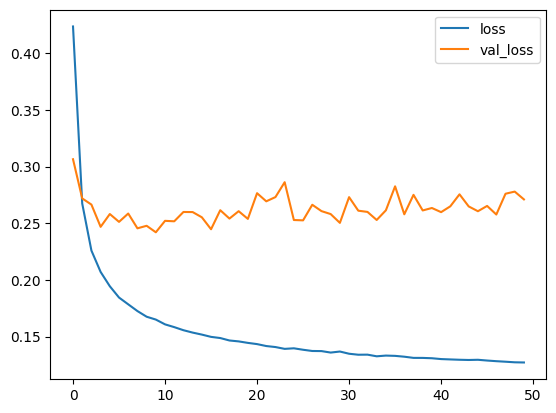

In [15]:

plt.figure()
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [16]:
unet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)

unet.compile(optimizer=OPTIMISER, loss=[LOSS, 'mse'], metrics=['accuracy'])
unet.load_weights(MODEL_FOLDER)
# Save Model


2024-01-13 04:27:32.514927: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open checkpoint: FAILED_PRECONDITION: checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
/home/cad04/MISA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
unet.save('model/unet_model.keras')

In [17]:
print("validation data",validation_images.shape)
print("validation mask", validation_masks.shape)

validation data (5, 256, 128, 256, 1)
validation mask (5, 256, 128, 256, 1)


In [5]:
# Load the model
unet = load_model('model/unet_model.keras')

2024-01-14 13:15:10.629083: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
# Assuming validation_masks is your original array with shape (5, 256, 128, 256, 1)
validation_masks = np.array(validation_masks)

# Remove the last dimension
validation_masks_squeezed = np.squeeze(validation_masks, axis=-1)

ds_score =[]
hd_score =[]
havd_score =[]

for i in range(len(validation_images)):
    prediction = unet.predict(x=validation_images[i,:,:,:,:])
    prediction = np.argmax(prediction, axis=3)

    gt_image = validation_masks_squeezed[i,:,:,:]

    ds_score.append(dice_score_per_class(prediction, gt_image))
    hd_score.append(hausdorff_distance_per_class(prediction, gt_image))
    havd_score.append(ravd_per_class(prediction, gt_image))
    print("Image: ",i)


8/8 [==============================] - 2s 237ms/step
Image:  0
8/8 [==============================] - 2s 253ms/step
Image:  1
8/8 [==============================] - 2s 270ms/step
Image:  2
8/8 [==============================] - 2s 218ms/step
Image:  3
8/8 [==============================] - 2s 242ms/step
Image:  4


In [9]:

print(tabulate(ds_score, tablefmt="grid"))
print(tabulate(hd_score, tablefmt="grid"))
print(tabulate(havd_score, tablefmt="grid"))

+----------+----------+----------+----------+
| 0.995468 | 0.597462 | 0.86061  | 0.899956 |
+----------+----------+----------+----------+
| 0.996941 | 0.836282 | 0.929202 | 0.889473 |
+----------+----------+----------+----------+
| 0.995992 | 0.888805 | 0.923285 | 0.882455 |
+----------+----------+----------+----------+
| 0.997109 | 0.892056 | 0.919666 | 0.915841 |
+----------+----------+----------+----------+
| 0.997609 | 0.880902 | 0.933784 | 0.912912 |
+----------+----------+----------+----------+
+---------+----------+----------+---------+
| 18.9737 | 139.496  |  81.3449 | 85.1234 |
+---------+----------+----------+---------+
| 19.7484 |  88.5889 |  67.72   | 90.8735 |
+---------+----------+----------+---------+
| 21.095  | 125.316  |  87.2983 | 63.5925 |
+---------+----------+----------+---------+
| 14.8661 | 118.229  | 102.747  | 72.1526 |
+---------+----------+----------+---------+
| 16.7631 | 138.932  |  81.6395 | 80.7527 |
+---------+----------+----------+---------+
+---------

In [10]:
# Function to calculate the average for each row
def calculate_row_average(row_data):
    return sum(row_data) / len(row_data)

In [27]:

# Convert the scores to a suitable format for tabulation
# We'll create a list of rows, where each row corresponds to an image
dice_data = []
hd_data = []
havd_data = []
for i in range(len(ds_score)):
        row = [f"Image {i + 1}"]
        
        row.extend(ds_score[i])

        hd_row = [f"Image {i + 1}"]
        hd_row.extend(hd_score[i])

        havd_row = [f"Image {i + 1}"]
        havd_row.extend(havd_score[i])

        avg_value = calculate_row_average(row[1:])
        dice_data.append(row + [avg_value])

        avg_value = calculate_row_average(hd_row[1:])
        hd_data.append(hd_row + [avg_value])

        avg_value = calculate_row_average(havd_row[1:])
        havd_data.append(havd_row + [avg_value])


# 0: Background, 1: CSF, 2: GM, 3: WM

tissue_headers = ["Background","CSF", "GM", "WM", "Average"]

# Updating the headers to reflect the tissue model
dice_headers = ["Image"] + tissue_headers
hd_headers = ["Image"] + tissue_headers
havd_headers = ["Image"] + tissue_headers

# Create and print the table
print(tabulate(dice_data, headers=dice_headers, tablefmt="grid"))
print(tabulate(hd_data, headers=hd_headers, tablefmt="grid"))
print(tabulate(havd_data, headers=havd_headers, tablefmt="grid"))

+---------+--------------+----------+----------+----------+-----------+
| Image   |   Background |      CSF |       GM |       WM |   Average |
+=========+==============+==========+==========+==========+===========+
| Image 1 |     0.995468 | 0.597462 | 0.86061  | 0.899956 |  0.838374 |
+---------+--------------+----------+----------+----------+-----------+
| Image 2 |     0.996941 | 0.836282 | 0.929202 | 0.889473 |  0.912974 |
+---------+--------------+----------+----------+----------+-----------+
| Image 3 |     0.995992 | 0.888805 | 0.923285 | 0.882455 |  0.922634 |
+---------+--------------+----------+----------+----------+-----------+
| Image 4 |     0.997109 | 0.892056 | 0.919666 | 0.915841 |  0.931168 |
+---------+--------------+----------+----------+----------+-----------+
| Image 5 |     0.997609 | 0.880902 | 0.933784 | 0.912912 |  0.931302 |
+---------+--------------+----------+----------+----------+-----------+
+---------+--------------+----------+----------+---------+------

5


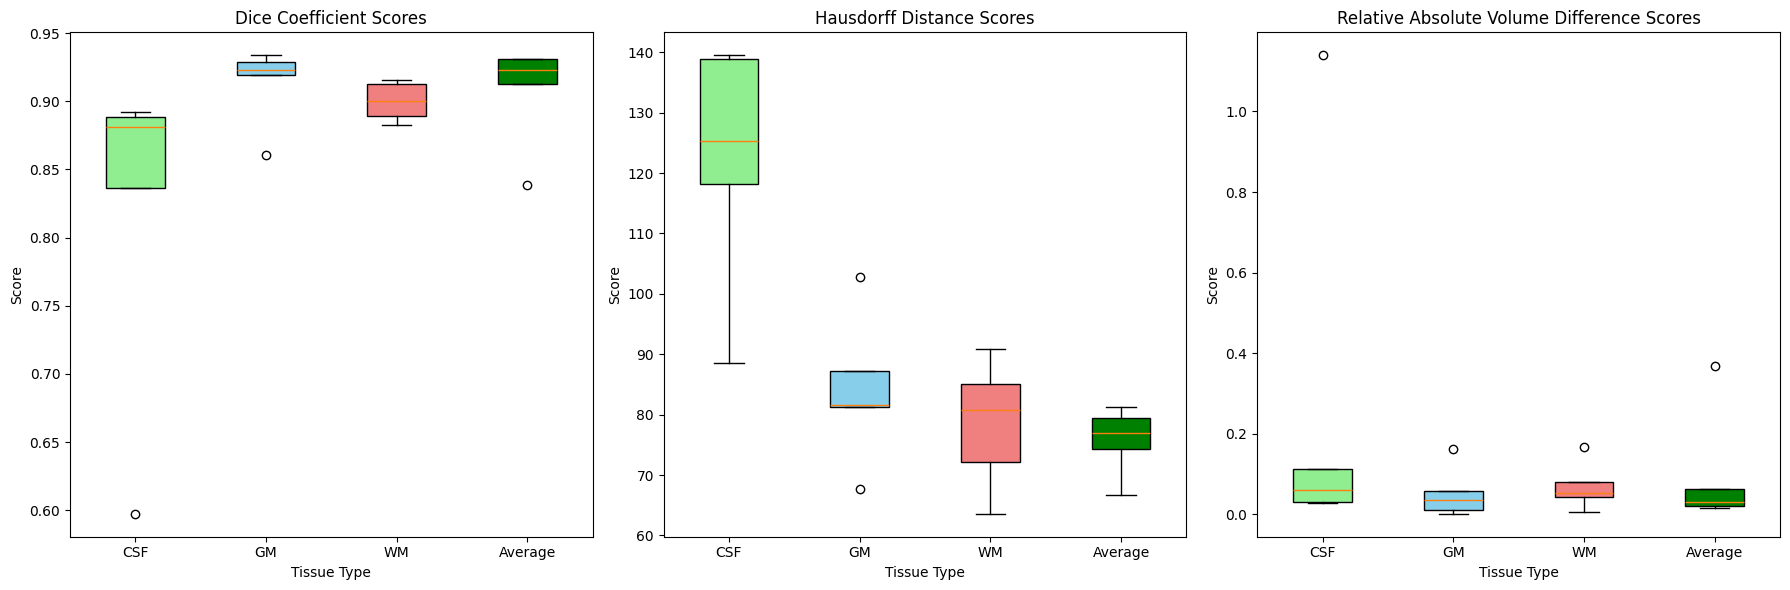

In [28]:


def boxplot(dice_data, hd_data, havd_data, tissue_headers):
    print(len(dice_data))
    # Extracting scores for each tissue type across all images
    # Assuming the first column in your data is the background, which we are skipping
    dice_scores_csf = [row[2] for row in dice_data]  # CSF scores
    dice_scores_gm = [row[3] for row in dice_data]  # GM scores
    dice_scores_wm = [row[4] for row in dice_data]  # WM scores
    dice_scores_avg = [row[5] for row in dice_data]  # WM scores

    hd_scores_csf = [row[2] for row in hd_data]  # CSF scores
    hd_scores_gm = [row[3] for row in hd_data]  # GM scores
    hd_scores_wm = [row[4] for row in hd_data]  # WM scores
    hd_scores_avg = [row[5] for row in hd_data]  # WM scores

    havd_scores_csf = [row[2] for row in havd_data]  # CSF scores
    havd_scores_gm = [row[3] for row in havd_data]  # GM scores
    havd_scores_wm = [row[4] for row in havd_data]  # WM scores
    havd_scores_avg = [row[5] for row in havd_data]  # WM scores

    # Define colors for each boxplot group
    colors = ['lightgreen', 'skyblue', 'lightcoral','green']

    # Creating boxplots for each set of scores
    plt.figure(figsize=(18, 6))

    # Dice Coefficient Scores
    plt.subplot(1, 3, 1)
    bplot1 = plt.boxplot([dice_scores_csf, dice_scores_gm, dice_scores_wm,dice_scores_avg], labels=tissue_headers[1:], patch_artist=True)
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('Dice Coefficient Scores')
    plt.xlabel('Tissue Type')
    plt.ylabel('Score')

    # Hausdorff Distance Scores
    plt.subplot(1, 3, 2)
    bplot2 = plt.boxplot([hd_scores_csf, hd_scores_gm, hd_scores_wm,hd_scores_avg], labels=tissue_headers[1:], patch_artist=True)
    for patch, color in zip(bplot2['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('Hausdorff Distance Scores')
    plt.xlabel('Tissue Type')
    plt.ylabel('Score')

    # Relative Absolute Volume Difference Scores
    plt.subplot(1, 3, 3)
    bplot3 = plt.boxplot([havd_scores_csf, havd_scores_gm, havd_scores_wm,havd_scores_avg], labels=tissue_headers[1:], patch_artist=True)
    for patch, color in zip(bplot3['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('Relative Absolute Volume Difference Scores')
    plt.xlabel('Tissue Type')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

boxplot(dice_data, hd_data, havd_data, tissue_headers)

In [6]:
test_images.shape

(3, 256, 128, 256, 1)

In [13]:

OUTPUT_FOLDER_PATH="TrainingValidationTestSets/Test_Mask/"

# List to hold the test predictions
predictions = []
for i, image in enumerate(test_images):
    prediction = unet.predict(x=test_images[i,:,:,:,:])
    prediction = np.argmax(prediction, axis=3)
    predictions.append(prediction)

def save_nifti_predictions(predictions, image_filenames):
      # Create the directory if it doesn't exist
    if not os.path.exists(OUTPUT_FOLDER_PATH):
        os.makedirs(OUTPUT_FOLDER_PATH)

    for pred, filename in zip(predictions, image_filenames):
        pred = pred.astype(np.int16)
        # Create a NIfTI image (assuming 'affine' is the transformation matrix of the original image)
        nifti_img = nib.Nifti1Image(pred, affine=np.eye(4))
        # Define the output path with the new suffix
        output_path = os.path.join(OUTPUT_FOLDER_PATH, f"{filename}_seg.nii.gz")
        # Save the NIfTI image
        nib.save(nifti_img, output_path)

# Call the function to save the predictions
save_nifti_predictions(predictions, test_image_names)

8/8 [==============================] - 2s 254ms/step


Test Images


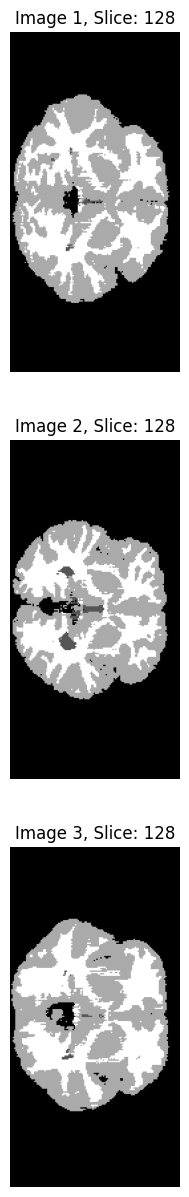

In [15]:
print("Test Images")
image_show_only(predictions)